# GRU를 활용한 언어 모형 생성 
---
RNN(순환신경망)의 대표 모형인 GRU를 활용한 영화 사이트 IMDB 리뷰 데이터 분류

## 1. GRU 활용 분류

### 데이터 불러오기 및 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb

In [2]:
(X_train, y_train),(X_test, y_test) = imdb.load_data()

In [3]:
print('훈련용 리뷰 개수: {}'.format(len(X_train)))
print('테스트용 리뷰 개수: {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리: {}'.format(num_classes))

훈련용 리뷰 개수: 25000
테스트용 리뷰 개수: 25000
카테고리: 2


In [4]:
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


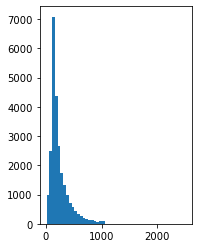

In [5]:
len_result = [len(s) for s in X_train]

print("리뷰의 최대 길이 : {}".format(np.max(len_result)))
print("리뷰의 평균 길이 : {}".format(np.mean(len_result)))

plt.subplot(1, 2, 2)
plt.hist(len_result, bins = 50)
plt.show()

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

print("각 레이블에 대한 빈도 수: ")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도 수: 
[[    0     1]
 [12500 12500]]


#### 단어와 정수값 매핑
---
>  IMDB 리뷰 데이터셋에서는 0, 1, 2, 3은 특별 토큰으로 취급하므로mldb.get.word_index + 3 해야 실제 매핑되는 정수로 볼 수 있음

In [7]:
word_to_index = imdb.get_word_index()

index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [8]:
# <pad>: padding, 길이를 맞출때 사용하는 비어있는(사용x) 토큰
# <sos>: start of sentence, 문장의 시작을 알리는 토큰
# <unk>: unknown, 모델이 인식할 수 없는 토큰

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] =token

In [9]:
# 첫 번째 리뷰 단어 매핑
print(" ".join([index_to_word[index] for index in X_train[0]]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

### 모델 만들기

In [10]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
# 리뷰 수를 1000개로 제한
vocab_size = 1000
(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [12]:
# 데이터가 정한 길이(500)을 초과하면 초과분을 삭제하고, 부족하면 0으로 채움

max_len = 500
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [13]:
# 단어 임베딩 설정 및 모델 구성

embedding_dim = 100     # 임베딩 후 벡터 크기
hidden_units = 128

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim)) # 임베딩 벡터의 차원을 100으로 설정
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100000    
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 188,449
Trainable params: 188,449
Non-trainable params: 0
_________________________________________________________________


### 학습하기

In [15]:
# 손실이 4회 증가하면 학습을 조기 종료
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience =4)
# 데이터 정확도가 이전보다 좋아질 경우에만 모델 저장
mc = ModelCheckpoint("GRU_model.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
334/334 [==============================] - ETA: 0s - loss: 0.5404 - acc: 0.7289
Epoch 1: val_acc improved from -inf to 0.79720, saving model to GRU_model.h5
334/334 [==============================] - 174s 515ms/step - loss: 0.5404 - acc: 0.7289 - val_loss: 0.4370 - val_acc: 0.7972
Epoch 2/10
334/334 [==============================] - ETA: 0s - loss: 0.4199 - acc: 0.8169
Epoch 2: val_acc improved from 0.79720 to 0.80460, saving model to GRU_model.h5
334/334 [==============================] - 183s 547ms/step - loss: 0.4199 - acc: 0.8169 - val_loss: 0.4497 - val_acc: 0.8046
Epoch 3/10
334/334 [==============================] - ETA: 0s - loss: 0.3592 - acc: 0.8480
Epoch 3: val_acc improved from 0.80460 to 0.85900, saving model to GRU_model.h5
334/334 [==============================] - 180s 540ms/step - loss: 0.3592 - acc: 0.8480 - val_loss: 0.3376 - val_acc: 0.8590
Epoch 4/10
334/334 [==============================] - ETA: 0s - loss: 0.3099 - acc: 0.8705
Epoch 4: val_acc improve

### 정확도 평가

In [17]:
# 조기 종료 모델 불러오기
loaded_model = load_model('GRU_model.h5')
print('\n 테스트 정확도: %4f'%(loaded_model.evaluate(X_test,y_test)[1]))

782/782 [==============================] - 64s 82ms/step - loss: 0.2863 - acc: 0.8806

 테스트 정확도: 0.880640
